In [4]:
import sys
sys.path.insert(0, "../deployment/update-db/src")

import pandas as pd
from toolbox import DatabaseInterface
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns


databaseInterface = DatabaseInterface()
def load_data(query):
    return(databaseInterface.select(query))

In [5]:
query_city = """
    SELECT article_date, content_cities.city, latitude, longitude
    FROM articles
    JOIN contents ON articles.id = contents.article_id
    JOIN content_cities ON contents.id = content_cities.content_id
    JOIN geocity ON content_cities.city = geocity.city
    ORDER BY article_date
    ;
    """
df_city = load_data(query_city)

In [6]:
df_city["city"] = df_city["city"].str.capitalize()

In [7]:
def countplot(df: pd.DataFrame, feature: str):
    chart = sns.countplot(df, x=feature, order=df[feature].value_counts().index)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=60, horizontalalignment='right')
    sns.set(rc={'figure.figsize':(10,5)});

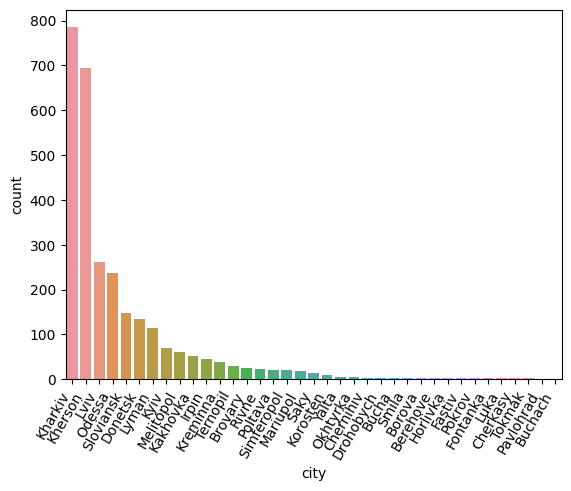

In [8]:
countplot(df_city, "city")

In [9]:
df_city

,article_date,city,latitude,longitude
0,2000-06-15 00:00:00,Odessa,46.484303,30.732288
1,2004-11-20 12:31:00,Lviv,49.841953,24.031591
2,2004-12-03 13:24:00,Kherson,46.542170,33.407932
3,2006-11-24 14:15:00,Kharkiv,49.992317,36.231014
4,2012-06-08 10:17:00,Lviv,49.841953,24.031591
...,...,...,...,...
2850,2023-03-10 08:29:00,Kharkiv,49.992317,36.231014
2851,2023-03-13 08:29:00,Lviv,49.841953,24.031591
2852,2023-03-17 15:00:00,Lviv,49.841953,24.031591
2853,2023-03-18 09:04:00,Kherson,46.542170,33.407932


In [10]:
df_mapcity = df_city.groupby(["city", "latitude", "longitude"]).count().sort_values("article_date", ascending=False).reset_index()
df_mapcity = df_mapcity.rename(columns={"article_date": "count"})

In [11]:
df_mapcity = df_mapcity.dropna()

In [12]:
df_mapcity

,city,latitude,longitude,count
0,Kharkiv,49.992317,36.231014,785
1,Kherson,46.542170,33.407932,695
2,Lviv,49.841953,24.031591,262
3,Odessa,46.484303,30.732288,237
4,Sloviansk,48.852270,37.605824,147
5,Donetsk,48.015877,37.801342,134
6,Lyman,43.917637,-99.858160,114
7,Kyiv,50.450035,30.524136,69
8,Melitopol,46.846725,35.382730,61
9,Kakhovka,46.805460,33.481780,52


In [13]:
import plotly.express as px

# Data with latitude/longitude and values
fig = px.scatter_mapbox(
    df_mapcity,
    lat="latitude",
    lon="longitude",
    size="count",
    color="count",
    color_continuous_scale=px.colors.cyclical.IceFire,
    hover_name="city",
    zoom=3,
    mapbox_style="open-street-map",
    height=700,
    size_max=40
)

fig.show()

In [155]:
import qwikidata.sparql
from geopy.geocoders import Nominatim
import time

def select_cities():
    """create dataframe [[city]]"""
    query = """
        SELECT city
        FROM geocity
        ;
        """

    cities = databaseInterface.select(query)

    return cities["city"]


def latitude(city: str):
    """return city's latitude"""
    # Initialize Nominatim API
    geolocator = Nominatim(user_agent="MyApp")
    location = geolocator.geocode(city)
    try:
        lat = location.latitude
        return lat
    except:
        print(city)


def longitude(city: str):
    """return city's longitude"""
    # Initialize Nominatim API
    geolocator = Nominatim(user_agent="MyApp")
    location = geolocator.geocode(city)
    try:
        lon = location.longitude
        return lon
    except:
        print(city)


def get_city_wikidata(city:str, country:str ='Ukraine'):
    langs = ['fr', 'en']
    for lang in langs:
        query = """
        SELECT ?city ?cityLabel ?country ?countryLabel ?population
        WHERE
        {
        ?city rdfs:label '%s'@%s.
        ?city wdt:P1082 ?population.
        ?city wdt:P17 ?country.
        ?city rdfs:label ?cityLabel.
        ?country rdfs:label ?countryLabel.
        FILTER(CONTAINS(?countryLabel, "%s")).
        }
        """ % (city, lang, country)
        
        try:
            res = qwikidata.sparql.return_sparql_query_results(query)
            out = res['results']['bindings'][0]
            return out['population']['value']
        except:
            pass
    print(f"[warning] population of {city} not found")


In [161]:
get_city_wikidata('Kiev')

'2952301'

In [162]:
query = """
    SELECT article_date, city
    FROM articles
    JOIN contents ON articles.id = contents.article_id
    JOIN content_cities ON contents.id = content_cities.content_id
    WHERE article_date > '2021-06-01'
    ORDER BY article_date
    ;
"""
df_city = databaseInterface.select(query)

cities = select_cities()
# for city in cities:
#     df_city = df_city.drop(df_city[df_city["city"] == city].index)
df_city["city"] = df_city["city"].str.capitalize()

df_geocity = (
    df_city.groupby(["city"])
    .count()
    .sort_values("article_date", ascending=False)
    .reset_index()
)
df_geocity = df_geocity.rename(columns={"article_date": "count"})
# df_geocity["latitude"] = df_geocity["city"].apply(latitude)
# df_geocity["longitude"] = df_geocity["city"].apply(longitude)
df_geocity["population_2023"] = df_geocity["city"].apply(get_city_wikidata)
df_geocity = df_geocity.dropna()

print(df_geocity)

[warning] population of Okhtyrka not found
[warning] population of Drohobych not found
[warning] population of Bucha not found
[warning] population of Chernihiv not found
[warning] population of Borodyanka not found
[warning] population of Borova not found
[warning] population of Smila not found
[warning] population of Cherkasy not found
[warning] population of Horlivka not found
[warning] population of Tokmak not found
[warning] population of Buchach not found
          city  count population_2023
0      Kharkiv    773         1433886
1      Kherson    693          283649
2         Lviv    255          724314
3       Odessa    231         1015826
4    Sloviansk    145          113196
5      Donetsk    128         1503400
6        Lyman    114           22315
7         Kyiv     69         2952301
8    Melitopol     61          154992
9     Kakhovka     52           35900
10       Irpin     46           56806
11    Kreminna     39           41084
12    Ternopil     30          225238
13

In [163]:
df_geocity

,city,count,population_2023
0,Kharkiv,773,1433886
1,Kherson,693,283649
2,Lviv,255,724314
3,Odessa,231,1015826
4,Sloviansk,145,113196
5,Donetsk,128,1503400
6,Lyman,114,22315
7,Kyiv,69,2952301
8,Melitopol,61,154992
9,Kakhovka,52,35900


In [3]:
import plotly.express as px
df = px.data.gapminder()
df

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,AFG,4
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,AFG,4
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,AFG,4
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,AFG,4
4,Afghanistan,Asia,1972,36.088,13079460,739.981106,AFG,4
...,...,...,...,...,...,...,...,...
1699,Zimbabwe,Africa,1987,62.351,9216418,706.157306,ZWE,716
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786,ZWE,716
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960,ZWE,716
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623,ZWE,716
